# preprocess `london` mocks for `spender`

In [63]:
import os, glob
import numpy as np 

In [9]:
import torch

In [2]:
import astropy.io.fits as fits
from astropy.table import Table

In [3]:
from spender.data import desi_qso

In [55]:
import matplotlib.pyplot as plt

In [4]:
desiQSO = desi_qso.DESI()

In [73]:
# i need to figure out what this directory corresponds to...
_dir = '/global/cfs/cdirs/desicollab/mocks/lya_forest/develop/london/qq_desi/v9.0_Y1/v9.0.9.9.9/desi-4.124-4-prod/spectra-16/'

def prepare_spectra(num0, num1, zbin='low'): 
    ''' prepare QSO spectra in healpix 
    '''
    # three files in each spectra directory...
    fspec = os.path.join(_dir, '%i/%i/spectra-16-%i.fits' % (num0, num1, num1))
    ftrue = os.path.join(_dir, '%i/%i/truth-16-%i.fits' % (num0, num1, num1))
    frred = os.path.join(_dir, '%i/%i/zbest-16-%i.fits' % (num0, num1, num1))
    
    # read spectra file
    hdulist = fits.open(fspec)
    meta = Table.read(fspec) # meta data
    zbest = Table.read(frred, hdu=1)
    z = zbest['Z'] 
    zerr = zbest['ZERR']
    
    target_id = meta['TARGETID'] # unique target ID
    
    if zbin == 'low': keep = (z < 2.1) 
    elif zbin == 'high': keep = (z > 2.1) & (z < 3.5)
    
    # read in data
    _wave, _flux, _ivar, _mask = {}, {}, {}, {} # res = {}
    for h in range(2, len(hdulist)):
        if "WAVELENGTH" in hdulist[h].header["EXTNAME"]:
            band = hdulist[h].header["EXTNAME"].split("_")[0].lower()
            _wave[band] = hdulist[h].data
        if "FLUX" in hdulist[h].header["EXTNAME"]:
            band = hdulist[h].header["EXTNAME"].split("_")[0].lower()
            _flux[band] = hdulist[h].data
        if "IVAR" in hdulist[h].header["EXTNAME"]:
            band = hdulist[h].header["EXTNAME"].split("_")[0].lower()
            _ivar[band] = hdulist[h].data
        if "MASK" in hdulist[h].header["EXTNAME"]:
            band = hdulist[h].header["EXTNAME"].split("_")[0].lower()
            _mask[band] = hdulist[h].data
        # no resolution data in the lond mocks 
        #if "RESOLUTION" in hdulist[h].header["EXTNAME"]:
        #    band = hdulist[h].header["EXTNAME"].split("_")[0].lower()
        #    _res[band] = hdulist[h].data
        
    # coadd the b, r, z arm spectra (scraped from
    # https://github.com/desihub/desispec/blob/main/py/desispec/coaddition.py#L529)
    tolerance = 0.001  # A , tolerance reduced
    wave = _wave["b"]
    for b in ["b", "r", "z"]:
        wave = np.append(wave, _wave[b][_wave[b] > wave[-1] + tolerance])
    nwave = wave.size
    ntarget = _flux["b"].shape[0]
    check_agreement = torch.abs(torch.from_numpy(wave) - desiQSO._wave_obs)
    #if check_agreement.max() > 0.01:
    #    print(
    #        "Warning: input wavelength grids inconsistent with class variable wave_obs!"
    #    )
    # check alignment, caching band wavelength grid indices as we go
    windict = {}
    number_of_overlapping_cameras = np.zeros(nwave)
    for b in ["b", "r", "z"]:
        imin = np.argmin(np.abs(_wave[b][0] - wave))
        windices = np.arange(imin, imin + len(_wave[b]), dtype=int)
        dwave = _wave[b] - wave[windices]
        if np.any(np.abs(dwave) > tolerance):
            msg = "Input wavelength grids (band '{}') are not aligned. Use --lin-step or --log10-step to resample to a common grid.".format(
                b
            )
            raise ValueError(msg)
        number_of_overlapping_cameras[windices] += 1
        windict[b] = windices

    flux = np.zeros((ntarget, nwave), dtype=_flux["b"].dtype)
    ivar = np.zeros((ntarget, nwave), dtype=_ivar["b"].dtype)
    ivar_unmasked = np.zeros((ntarget, nwave), dtype=_ivar["b"].dtype)
    mask = np.zeros((ntarget, nwave), dtype=_mask["b"].dtype)

    for b in ["b", "r", "z"]:
        # indices
        windices = windict[b]

        for i in range(ntarget):
            ivar_unmasked[i, windices] += np.sum(_ivar[b][i], axis=0)
            ivar[i, windices] += _ivar[b][i] * (_mask[b][i] == 0)
            flux[i, windices] += _ivar[b][i] * (_mask[b][i] == 0) * _flux[b][i]

            # directly copy mask where no overlap
            jj = number_of_overlapping_cameras[windices] == 1
            mask[i, windices[jj]] = _mask[b][i][jj]

            # 'and' in overlapping regions
            jj = number_of_overlapping_cameras[windices] > 1
            mask[i, windices[jj]] = mask[i, windices[jj]] & _mask[b][i][jj]

    for i in range(ntarget):
        ok = ivar[i] > 0
        if np.sum(ok) > 0:
            flux[i][ok] /= ivar[i][ok]
        ok = ivar_unmasked[i] > 0
            
    # apply bitmask, remove small values
    mask = mask.astype(bool) | (ivar <= 1e-6)
    ivar[mask] = 0

    # explicit type conversion to float32 to get to little endian
    spec = torch.from_numpy(flux[keep].astype(np.float32))
    w = torch.from_numpy(ivar[keep].astype(np.float32))
    target_id = torch.from_numpy(target_id[keep].astype(np.int64))

    # remove regions around skylines
    w[:, desiQSO._skyline_mask] = 0
    
    z = torch.tensor(z[keep].astype(np.float32))
    zerr = torch.tensor(zerr[keep].astype(np.float32))
    
    # normalize spectra:
    norm = torch.zeros(np.sum(keep))
    for i in range(np.sum(keep)):
        # for redshift invariant encoder: select norm window in restframe
        wave_rest = desiQSO._wave_obs / (1 + z[i])
        # wavelength range with no spectral lines
        if zbin == 'low': 
            sel = (w[i] > 0) & (wave_rest > 2500) & (wave_rest < 2700) #(wave_rest > 5300) & (wave_rest < 5850)
        elif zbin == 'high': 
            # this wavelength range is set by the CIII absorprtion wavelengths. 
            # CIII absorption is small and thus should not contribute significantly
            # to estimating the normalization
            sel = (w[i] > 0) & (wave_rest > 1600) & (wave_rest < 1800) #(wave_rest > 5300) & (wave_rest < 5850)
        else: 
            raise NotImplementedError
        if sel.count_nonzero() > 0:
            norm[i] = torch.median(spec[i][sel])
        # remove spectra (from training) for which no valid norm could be found
        if not torch.isfinite(norm[i]):
            norm[i] = 0
        else:
            spec[i] /= norm[i]
        w[i] *= norm[i]**2

    # selects finite fluxes
    keep = (spec.isfinite().sum(axis=-1) == nwave).numpy()
    print("%i, %i --- keep: %d / %d"%(num0, num1, keep.sum(),len(keep)))
    return spec[keep], w[keep], z[keep], target_id[keep],  norm[keep], zerr[keep]

test preprocessing

In [53]:
# save QSO spectra to batch
spec, w, z, target_id, norm, zerr = prepare_spectra(0, 0, zbin='high')

keep: 546 / 546


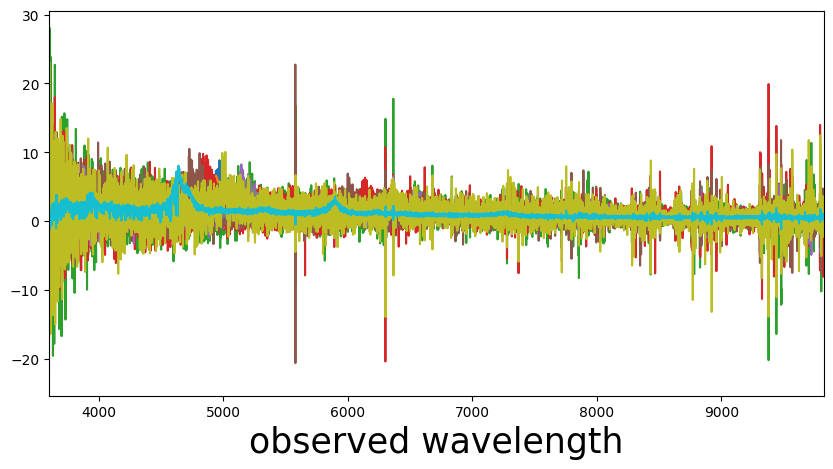

In [74]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
for igal in range(10): 
    offset = igal * 10
    sub.plot(desiQSO.wave_obs, spec[igal])
sub.set_xlim(desiQSO.wave_obs[0], desiQSO.wave_obs[-1])
sub.set_xlabel('observed wavelength', fontsize=25)
plt.show()    

In [75]:
# save QSO spectra to batch
batch_size = 1024

counter, new_batch = 0, True

for dir_num0 in glob.glob('%s/*' % _dir): 
    dirs_num1 = glob.glob('%s/*' % dir_num0)
    for dir_num1 in dirs_num1: 
        num0 = int(dir_num0.split('/')[-1])
        num1 = int(dir_num1.split('/')[-1])
        if len(glob.glob('%s/*' % dir_num1)) == 0: continue 
        
        spec, w, z, target_id, norm, zerr = prepare_spectra(num0, num1, zbin='high')
        
        if new_batch:
            batches = [spec, w, z, target_id, norm, zerr]
            new_batch = False
        else:
            batches[0] = torch.concatenate([batches[0], spec], axis=0)
            batches[1] = torch.concatenate([batches[1], w], axis=0)
            batches[2] = torch.concatenate([batches[2], z], axis=0)
            batches[3] = torch.concatenate([batches[3], target_id], axis=0)
            batches[4] = torch.concatenate([batches[4], norm], axis=0)
            batches[5] = torch.concatenate([batches[5], zerr], axis=0)

        N = batches[0].shape[0]
        while N > batch_size:
            batch = [_batch[:batch_size] for _batch in batches]

            print(f"saving batch {counter}")
            desiQSO.save_batch('/global/cfs/projectdirs/desi/users/chahah/spender_qso', batch, tag='london_highz', counter=counter)
            counter += 1
            N -= batch_size

            batches = [_batch[batch_size:] for _batch in batches]

7, 789 --- keep: 278 / 278
7, 785 --- keep: 234 / 234
7, 777 --- keep: 10 / 10
7, 773 --- keep: 155 / 155
7, 791 --- keep: 251 / 251
7, 706 --- keep: 104 / 104
saving batch 0
7, 786 --- keep: 18 / 18
7, 774 --- keep: 96 / 96
7, 724 --- keep: 189 / 189
7, 787 --- keep: 271 / 271
7, 725 --- keep: 60 / 60
7, 793 --- keep: 8 / 8
7, 726 --- keep: 25 / 25
7, 768 --- keep: 703 / 703
saving batch 1
7, 790 --- keep: 135 / 135
7, 770 --- keep: 335 / 335
7, 769 --- keep: 647 / 647
saving batch 2
7, 799 --- keep: 57 / 57
7, 771 --- keep: 407 / 407
7, 704 --- keep: 160 / 160
saving batch 3
7, 788 --- keep: 178 / 178
7, 784 --- keep: 243 / 243
7, 772 --- keep: 494 / 494
7, 797 --- keep: 128 / 128
saving batch 4
6, 630 --- keep: 376 / 376
6, 672 --- keep: 670 / 670
saving batch 5
6, 660 --- keep: 444 / 444
6, 629 --- keep: 263 / 263
6, 617 --- keep: 453 / 453
saving batch 6
6, 659 --- keep: 489 / 489
6, 609 --- keep: 750 / 750
saving batch 7
6, 605 --- keep: 339 / 339
6, 647 --- keep: 719 / 719
savin

KeyboardInterrupt: 